# This notebook shows how to fit a resonator with Kerr nonlinearity in the reflection configuration.

In [30]:
%cd D:\Github\rf-analysis-tools\src
from __future__ import division, absolute_import, print_function


%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from resonator import background, reflection, see,kerr



D:\Github\rf-analysis-tools\src


Create data using the model plus gaussian noise. The model is the product of the nonlinear reflection resonator model and a background model, which in this case assumes that the magnitude and phase are independent of frequency.

When the input photon rate exceeds a critical value, the photon number in the resonator has two stable states (and one unstable state that cannot be observed) that correpond to the roots of a cubic polynomial. A typical VNA sweep with increasing frequency is expected to cause the resonator to track the branch corresponding to lower photon number. When fitting, the model for the scattering data must select one of these branches. The `choose` function below is used to choose one of the roots. 

In [23]:
# Background parameters
background_model = background.MagnitudePhase()
magnitude = 0.01
phase = -np.pi / 2

# Select the root corresponding to maximum detuning, not minimum photon number -- these may differ.
choose = np.max

# Foreground parameters
foreground_model = reflection.KerrReflection(choose=choose)
f_r = 1e9  # resonance frequency
df = 2e6  # frequency width
f = np.linspace(f_r - df / 2, f_r + df / 2, 2001)
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000
# This value of the parameter kerr_input implies a negative Kerr coefficient and a value of the input photon rate that is well above the point
# where the resonator has two stable states with different photon number.
critical_kerr_input = foreground_model.absolute_kerr_input_at_bifurcation(coupling_loss=coupling_loss, internal_loss=internal_loss)
kerr_input = -1.5 * critical_kerr_input

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=f, magnitude=magnitude, phase=phase)
fg = foreground_model.func(frequency=f, resonance_frequency=f_r, internal_loss=internal_loss, coupling_loss=coupling_loss,
                           kerr_input=kerr_input)

# The ideal data is the product of the background and foreground.
s21 = bg * fg

# The measured data will include noise
noise = 0.005 * magnitude
s21n = s21 + noise * (np.random.randn(s21.size) + 1j * np.random.randn(s21.size))

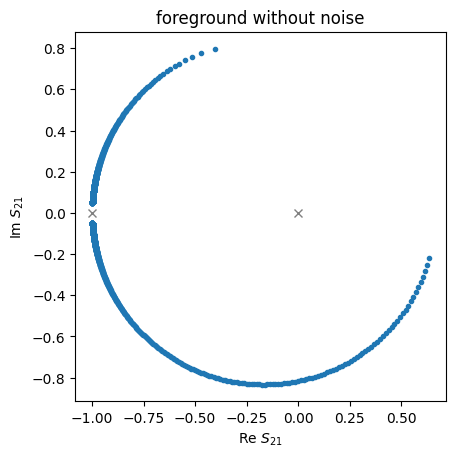

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(fg.real, fg.imag, '.')
ax.plot([0, -1], [0, 0], marker='x', linestyle='none', color='gray')
ax.set_title('foreground without noise');

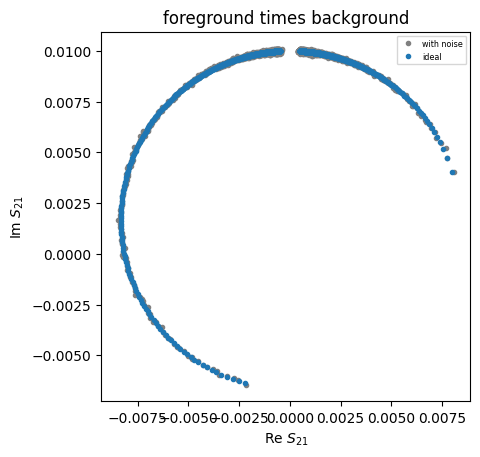

In [24]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(s21n.real, s21n.imag, '.', color='gray', label='with noise')
ax.plot(s21.real, s21.imag, '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

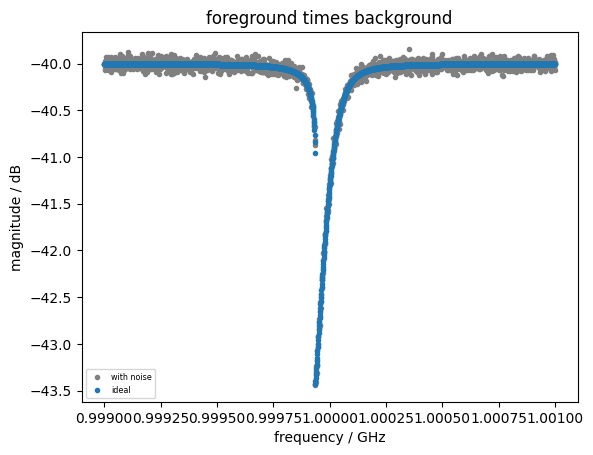

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('magnitude / dB')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21n)), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21)), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

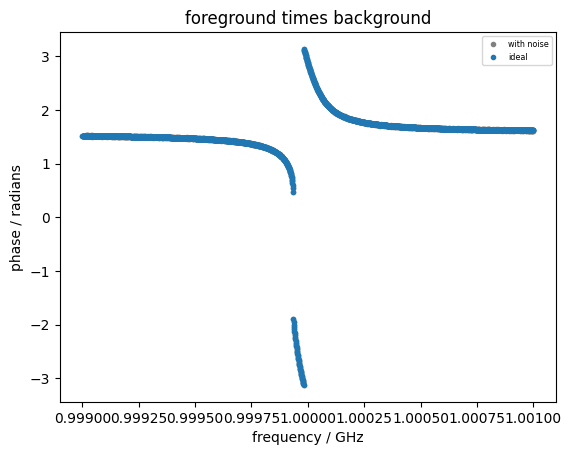

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('phase / radians')
ax.plot(1e-9 * f, np.angle(s21n), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, np.angle(s21), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

## Fit the model to the data using a KerrReflectionFitter.

Here, we know the standard error of each data point because we added the noise. If no errors are given, the fitting assumes equal errors for each point and thus equal weights, so errors are not generally necessary unless they vary between points.

In [16]:
resonator = reflection.KerrReflectionFitter(frequency=f, data=s21n, choose=choose)
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(magnitude_phase) * Model(kerr_reflection))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 4002
    # variables        = 6
    chi-square         = 0.01645415
    reduced chi-square = 4.1177e-06
    Akaike info crit   = -49619.7120
    Bayesian info crit = -49581.9447
    R-squared          = (0.8398551221408795+0.5120155574675386j)
[[Variables]]
    magnitude:            0.00995958 +/- 4.8959e-05 (0.49%) (init = 0.009959584)
    phase:               -1.51592959 +/- 0.01345894 (0.89%) (init = -1.51593)
    resonance_frequency:  9.9999e+08 +/- 735.339638 (0.00%) (init = 9.999885e+08)
    coupling_loss:        6.7472e-05 +/- 1.1099e-05 (16.45%) (init = 6.747246e-05)
    internal_loss:        6.5284e-06 +/- 1.0870e-05 (166.50%) (init = 6.528392e-06)
    kerr_input:           0.00000000 +/- 1.6132e-06 (inf%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(coupling_loss, kerr_input)        

## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance.

C:\Users\Amine Selmani\AppData\Local\Temp\ipykernel_25248\223770844.py:6: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 3
  ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');


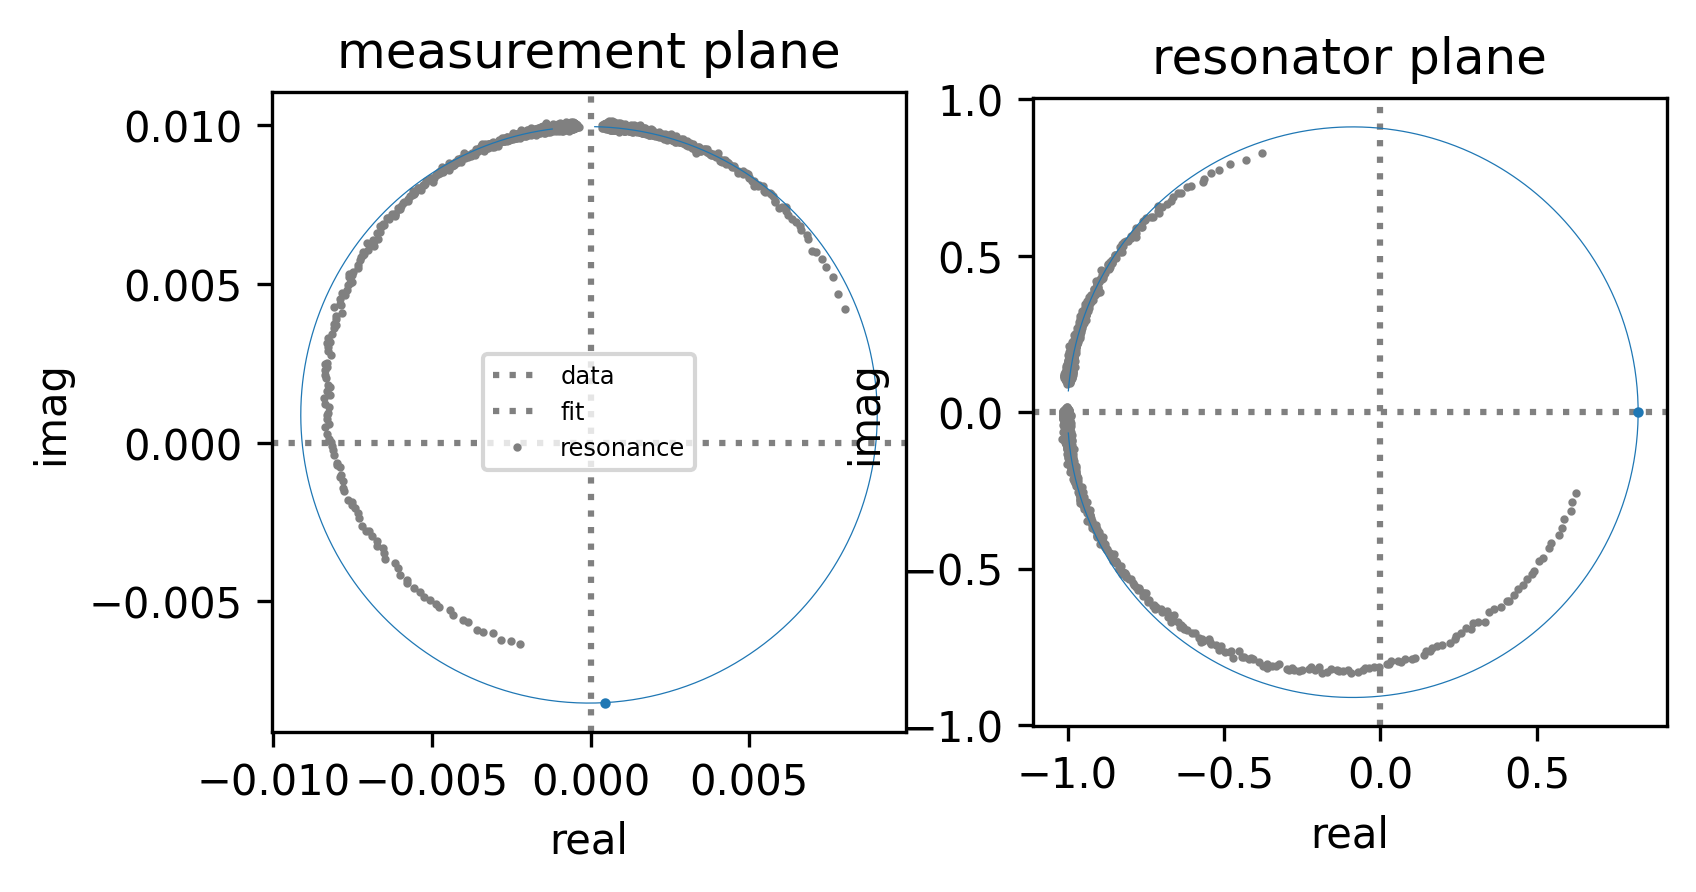

In [17]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)  # Adjust these values for your plot settings
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');

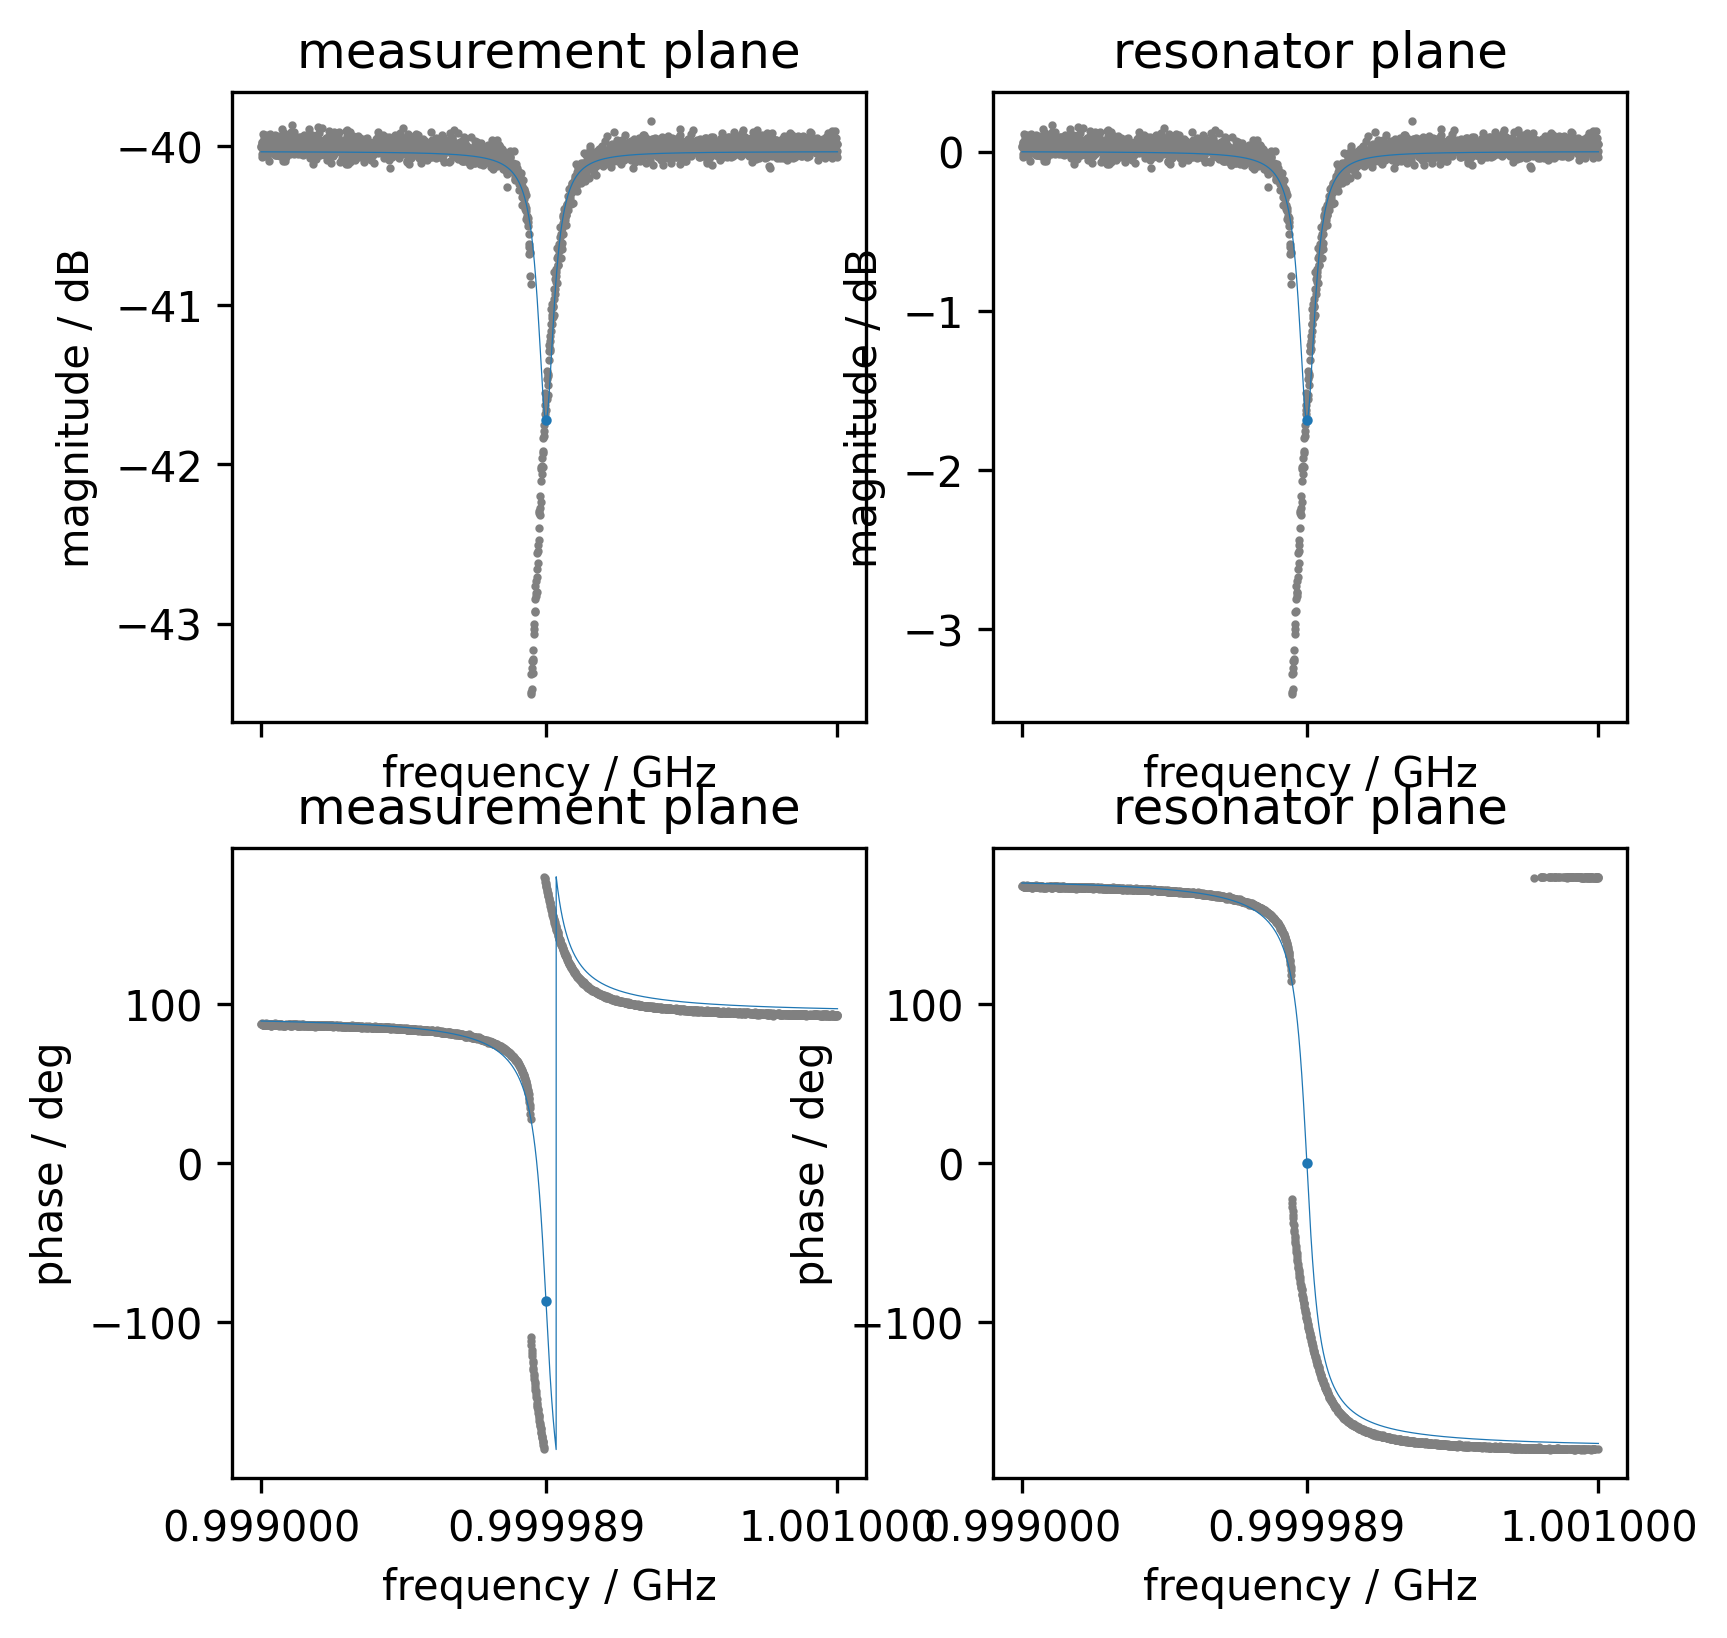

In [18]:
fig, axes = plt.subplots(2, 2, sharex='all', figsize=(6, 6), dpi=300)  # Adjust these values for your plot settings
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);

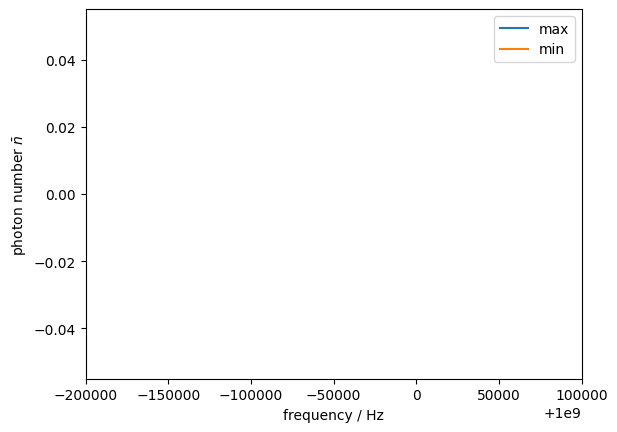

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / Hz')
ax.set_ylabel(r'photon number $\bar{n}$')
ax.plot(f, resonator.photon_number(input_frequency=f, input_rate=resonator.f_r), label='max')
# Calculate the photon number using another root-finding function that selects the minimum Kerr detuning.
# Since the Kerr coefficient is negative here the Kerr detuning is also negative, so choosing the minimum
# (most negative) detuning corresponds to choosing the maximum photon number.
ax.plot(f, resonator.photon_number(input_frequency=f, input_rate=resonator.f_r, choose=np.min), label='min')
ax.legend()
ax.set_xlim(f_r - 2e5, f_r + 1e5);